# **Unsupervised Learning**

**Definition**

Unsupervised learning refers to most attempts to extract information from a distribution that do not require human labor to annotate example
Main task is to find the 'best' representation of the data

**Dimension Reduction**

Attempt to compress as much information as possible in a smaller representation
Preserve as much information as possible while obeying some constraint aimed at keeping the representatio

# **Autoencoders**

It is like 'deep learning version' of unsupervised learning.

**Definition**

An autoencoder is a neural network that is trained to attempt to copy its input to its output
The network consists of two parts: an encoder and a decoder that produce a reconstruction

# **IMPORT**

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard

# **Load Data**

In [3]:
path_to_file_drive_norm = "/content/drive/My Drive/Estudios/URJC_PHD/Paper2/data/biclase/"
path_data_x_train= path_to_file_drive_norm + 'x_train.mat'
path_data_x_test= path_to_file_drive_norm + 'x_test.mat'
path_data_y_train= path_to_file_drive_norm + 'y_train.mat'
path_data_y_test= path_to_file_drive_norm + 'y_test.mat'

In [4]:
x_train_mat = io.loadmat(path_data_x_train)
x_test_mat = io.loadmat(path_data_x_test)
y_train_mat = io.loadmat(path_data_y_train)
y_test_mat = io.loadmat(path_data_y_test)

x_train_aux= x_train_mat['x_train']
x_train=x_train_aux.transpose()
x_test_aux= x_test_mat['x_test']
x_test= x_test_aux.transpose()

y_train= y_train_mat['y_train']
y_test= y_test_mat['y_test']

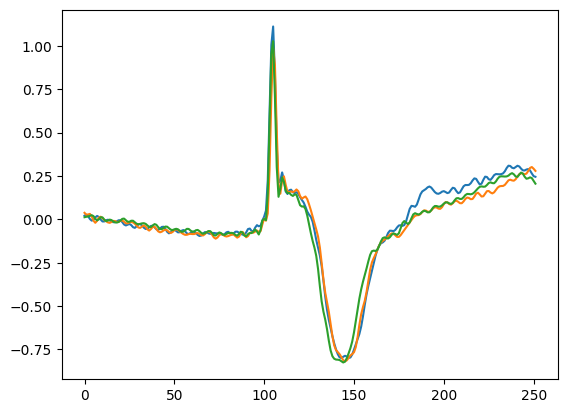

In [5]:
plt.plot(x_test.transpose()[:,1:4])
plt.show()

In [ ]:
x_test2=x_test+2

In [ ]:
plt.plot(x_test2.transpose()[:,1:4])
plt.show()

In [ ]:
# this is the size of our encoded representations
encoding_dim = 252
input_dim = 252

# this is our input placeholder
input_img = Input(shape=(input_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='relu')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')

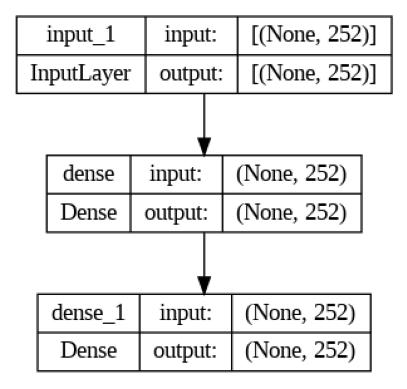

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
plt.axis("off")
plt.imshow(mpimg.imread('model_plot.png'))
plt.show()

# **Definicion clase autoencoder**

In [15]:
import json

class myAutoencoder():
    def __init__(self, encoding_dim,input_dim,loss, optimizer, capas=[]):
        self.encoding_dim = encoding_dim
        self.input_dim = input_dim
        self.loss = loss
        self.optimizer = optimizer
        self.autoencoder = None
        self.capas = capas

    def generate_model2(self):
        # this is our input placeholder
        input_img = Input(shape=(self.input_dim,))

        cont = 0
        for capa in self.capas:
          if cont == 0:
            encoded = Dense(capa, activation='relu')(input_img)
          else:
            encoded = Dense(capa, activation='relu')(encoded)
          cont = cont + 1

        if cont ==0:
          encoded = Dense(self.encoding_dim, activation='relu')(input_img)
        else:
          encoded = Dense(self.encoding_dim, activation='relu')(encoded)

        cont = 0
        for capa in reversed(self.capas):
          if cont == 0:
            decoded = Dense(capa, activation='relu')(encoded)
          else:
            decoded = Dense(capa, activation='relu')(decoded)
          cont = cont + 1
        if cont ==0:
          decoded = Dense(self.input_dim, activation='relu')(encoded)
        else:
          decoded = Dense(self.input_dim, activation='relu')(decoded)
        # this model maps an input to its reconstruction
        autoencoder = Model(input_img, decoded)

        autoencoder.compile(loss=self.loss, optimizer=self.optimizer)
        self.autoencoder = autoencoder

    def get_encoder(self):
      num_layer = len(self.capas) + 1
      return Model(self.autoencoder.input, self.autoencoder.layers[num_layer].output)

    def get_decoder(self):
      decoder_input = Input(shape=(self.encoding_dim,))
      cont = 0
      for capa in reversed(self.capas):
        if cont == 0:
            decoded = Dense(capa, activation='relu')(decoder_input)
            cont = cont + 1
        else:
            decoded = Dense(capa, activation='relu')(decoded)

      if cont ==0:
        decoded = Dense(input_dim, activation='relu')(decoder_input)
      else:
        decoded = Dense(input_dim, activation='relu')(decoded)

      decoder = Model(decoder_input, decoded)
      encoder = self.get_encoder()
      for i in range(1, len(decoder.layers)):
        decoder.layers[i].set_weights(self.autoencoder.layers[len(encoder.layers)+i-1].get_weights())

      return decoder
      
    def check(self, instance):
        #latido_prueba = np.array([x_test[10]])
        encoder = self.get_encoder()
        decoder = self.get_decoder()

        encoded_datapoints = encoder.predict(instance)
        decoded_datapoints = decoder.predict(encoded_datapoints)

        autoencoder_datapoints=self.autoencoder.predict(instance)

        #print('Original Datapoints :')
        #print(x_test)
        print('Reconstructed Datapoints :')
        print(decoded_datapoints[0][1:15])
        print('Autoencoders datapoint')
        print(autoencoder_datapoints[0][1:15])
        print(decoded_datapoints[0] == autoencoder_datapoints[0])      

    def fit(self, x_train, x_test, epochs, batch_size, shuffle=True):
      return self.autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=shuffle,
                  validation_data=(x_test, x_test))

    def save(self, nameFile):
      self.autoencoder.save(nameFile)
      
      data = { 'encoding_dim': self.encoding_dim,
              'input_dim':   self.input_dim,
              'loss':  self.loss,
              'optimizer': self.optimizer,
              'capas': self.capas
      } 
      json_string = json.dumps(data)
      file_name = nameFile + '.json'
      with open(file_name, 'w') as outfile:
        json.dump(json_string, outfile)

    def load(self, nameFile):
      self.autoencoder = keras.models.load_model(nameFile, compile=False) 
      json_file = nameFile + '.json'
      with open(json_file, 'r') as f:
        aux_str = json.load(f)
      aux= json.loads(aux_str)
    
      self.encoding_dim = aux['encoding_dim']
      self.input_dim = aux['input_dim']
      self.loss = aux['loss']
      self.optimizer = aux['optimizer']
      self.capas = aux['capas']

In [16]:
def grid_fit(x_train, x_test, encoding_dim,input_dim,loss, optimizer,epochs,batch_size, capas=[], plot=True):

    #autoencoder = generate_model(encoding_dim,input_dim,loss, optimizer)
    for capa in capas:
      autoencoder = myAutoencoder(encoding_dim=encoding_dim,input_dim=input_dim,loss=loss, optimizer=optimizer, capas=capa)
      autoencoder.generate_model2()

      best_loss = 1
      best_model, best_history = None, None
      for i in range(len(batch_size)):
        history  = autoencoder.fit(x_train, x_test, epochs, batch_size=batch_size[i],shuffle=True)

        if plot:
          plt.plot(history.history['loss'])
          plt.plot(history.history['val_loss'])
          plt.title('model loss: '+ str(batch_size[i]) + ' ' + str(capa))
          plt.ylabel('loss')
          plt.xlabel('epoch')
          plt.legend(['train', 'test'], loc='upper left')
          plt.show()
          
        if history.history['loss'][-1] < best_loss:
          best_loss = history.history['loss'][-1]
          best_model = autoencoder
          best_history = history
          print(capa, batch_size[i], epochs)
    return best_model, best_history


Epoch 1/3
3053/3053 [==============================] - 30s 8ms/step - loss: 0.0854 - val_loss: 0.1112
Epoch 2/3
3053/3053 [==============================] - 21s 7ms/step - loss: 0.0636 - val_loss: 0.1067
Epoch 3/3
3053/3053 [==============================] - 16s 5ms/step - loss: 0.0606 - val_loss: 0.1033


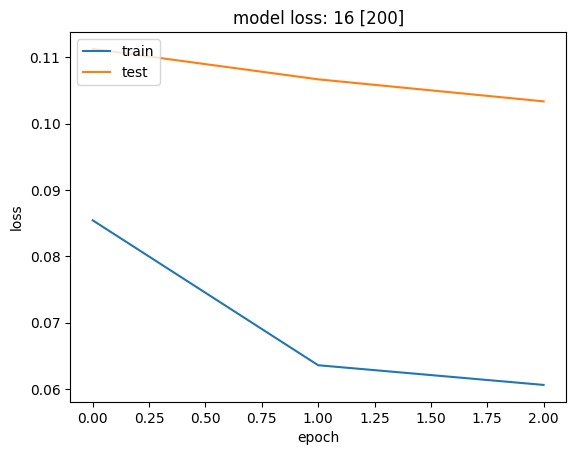

[200] 16 3


In [17]:
encoding_dim = 126
input_dim = 252
#epochs=80
epochs=3
batch_size=[16] #, 16] #, 32, 64, 128]
capas = [[200]] #-> 0.9091
#capas = [504] #-> 0.9091
loss='mean_squared_error'
optimizer='sgd'
#autoencoder_fit(encoding_dim,input_dim,loss, optimizer,epochs,batch_size)
best_model, best_history=grid_fit(x_train, x_test, encoding_dim,input_dim,loss, optimizer,epochs,batch_size, capas)
#best_model.check(np.array([x_test[10]]))

# **OTROS**

In [ ]:
def autoencoder_fit(encoding_dim,input_dim,loss, optimizer,epochs,batch_size):

    # this is our input placeholder
    input_img = Input(shape=(input_dim,))

    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)

    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation='relu')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    autoencoder.compile(loss=loss, optimizer=optimizer)

    for i in range(len(batch_size)):
      history  = autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=batch_size[i],
                  shuffle=True,
                  validation_data=(x_test, x_test))
      # list all data in history
      print(history.history.keys())
      # summarize history for accuracy
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss: '+ str(i))
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.show()
    #return history

Epoch 1/3
1628/1628 [==============================] - 8s 5ms/step - loss: -18.5699 - val_loss: -82.3224
Epoch 2/3
1628/1628 [==============================] - 9s 5ms/step - loss: -46.2181 - val_loss: -98.2966
Epoch 3/3
1628/1628 [==============================] - 7s 5ms/step - loss: -50.5513 - val_loss: -102.9450
dict_keys(['loss', 'val_loss'])


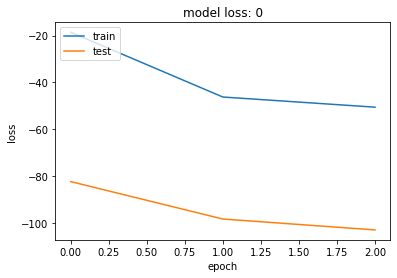

In [ ]:
# this is the size of our encoded representations
encoding_dim = 252
input_dim = 252
epochs=3
batch_size=[30]
#loss=['mean_squared_error', 'categorical_crossentropy']
loss='categorical_crossentropy'
optimizer='sgd'
autoencoder_fit(encoding_dim,input_dim,loss, optimizer,epochs,batch_size)
#history=autoencoder_fit(epochs,batch_size,autoencoder)


In [ ]:
'''
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (2-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
'''

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

SyntaxError: ignored

In [ ]:
# encode and decode some data points
# note that we take them from the *test* set
latido_prueba = np.array([x_test[10]])
encoder = Model(autoencoder.input, autoencoder.layers[-2].output)

encoded_datapoints = encoder.predict(latido_prueba)

decoder_input = Input(shape=(encoding_dim,))
decoder = Model(decoder_input, autoencoder.layers[-1](decoder_input))

decoded_datapoints = decoder.predict(encoded_datapoints)

autoencoder_datapoints=autoencoder.predict(latido_prueba)

#print('Original Datapoints :')
#print(x_test)
print('Reconstructed Datapoints :')
print(decoded_datapoints[0][1:5])
print('Autoencoders datapoint')
print(autoencoder_datapoints[0][1:5])

1/1 [==============================] - 0s 61ms/step
Reconstructed Datapoints :
[0. 0. 0. 0.]
Autoencoders datapoint
[0. 0. 0. 0.]


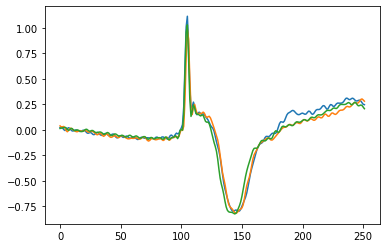

In [ ]:
plt.plot(x_test.transpose()[:,1:4])
plt.show()

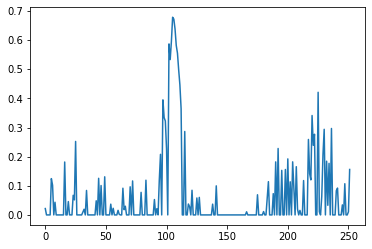

In [ ]:
plt.plot(autoencoder_datapoints.transpose())
plt.show()